Poincare plots (Wendelstein 7-X)
================================

This example shows how to create Poincare plots for Wendelstein 7-X. First, we need to perform some setup to make sure W7-X data are available.

In [1]:
import fsc
from fsc.devices import w7x

In [2]:
fsc.resolve.importOfflineData('../../w7x.fsc')

Now we need to setup the geometry and magnetic field configuration.

In [3]:
field = w7x.standard()
geometry = w7x.op12Geometry()

grid = w7x.defaultGrid.clone()
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

Finally, we need to decide in which phi planes we want to evaluate our Poincare plots, and which points to start our traces on.

In [4]:
import numpy as np
phiPlanes = np.linspace(0, 2 / 5 * np.pi, 5, endpoint = False)

startPoints = np.linspace([5.8, 0, 0], [6.3, 0, 0], 20, axis = 1)

Now it's time to run our calculation.

In [5]:
tracer = fsc.tracer()
pcPoints = tracer.poincareInPhiPlanes(
    startPoints, phiPlanes, 200,
    field, grid = grid,
    geometry = geometry, geometryGrid = w7x.defaultGeometryGrid,
    distanceLimit = 1e4
)

The calculation returns a numpy array with a specific shape:
- The first dimension of the array is always 5. The first 3 entries are the x, y, z positions of the intersection points, while the other 2 are forward and backward connection-lengths. Negative values indicate, that the respective length (given by the absolute value) is given by something other than a collision event (start point, tracing limit, leaving the grid, etc.)
- The second dimension corresponds to the selected phi values to do the intersection at.
- The third dimension on corresponds to the dimensions of the starting point array (excluding its first xyz dimension)
- Finally, the last dimension corresponds to the turn counter of the field line.

In [6]:
# Shape is [5, nPlanes] + startsPoints.shape[1:] + [nTurns]
pcPoints.shape

(5, 5, 20, 200)

We can now plot each series of intersection points. For this, we can also make use of the fsc.geometry.plotCut function, which will compute phi slices of the geometry.

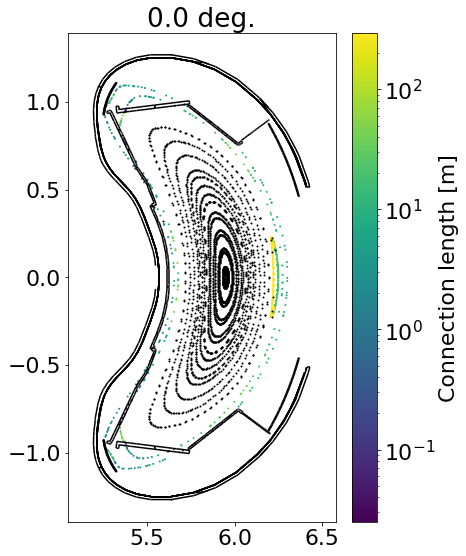

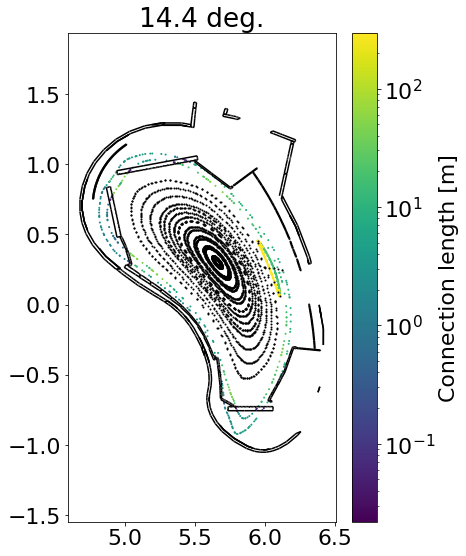

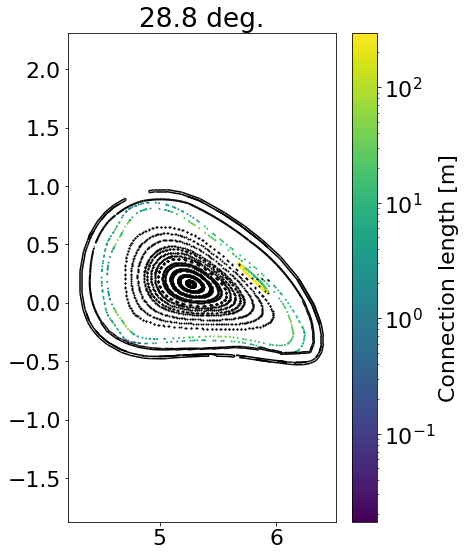

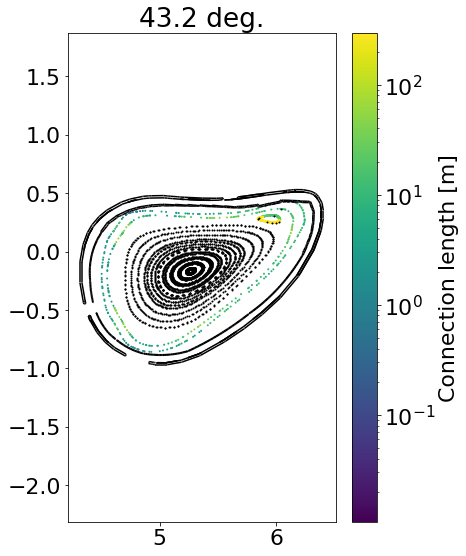

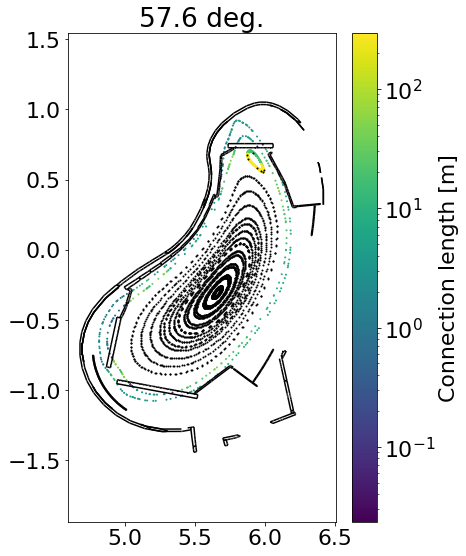

In [11]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

for iPhi, phi in enumerate(phiPlanes):
    x, y, z, cLenF, cLenB = pcPoints[:, iPhi, :, :].reshape([5, -1])
    r = np.sqrt(x**2 + y**2)
    
    # Negative connection lengths indicate that the line segment going through
    # the point in that direction is not terminated by collision (e.g. it left
    # the grid or hit the distance limit)
    mask = np.logical_and(cLenF > 0, cLenB > 0)
    
    cLen = cLenF + cLenB
    
    plt.figure(figsize = (6, 9))
    plt.title(str(np.degrees(phi)) + ' deg.')
    plt.scatter(r[mask], z[mask], c = cLen[mask], norm = matplotlib.colors.LogNorm(), s = 1)
    plt.colorbar(label = 'Connection length [m]')
    plt.scatter(r[~mask], z[~mask], c = 'k', s = 1)
    
    fsc.geometry.plotCut(geometry, float(phi), edgecolors = 'k')
    plt.axis('equal')